# MultiModal Classification (Text + Image) on Fakeddit Dataset
- Fakeddit is a fine-grained multimodal fake news detection dataset, designed to advance efforts to combat the spread of misinformation in multiple modalities.
- I worked on classifying data into 6 pre-defined classes: authentic/true news content, Satire/Parody, content with false connection, imposter content, manipulated content and misleading content.
- In the Image-Feature Extractor, I used a pre-trained `ResNet50 model` trained on the ImageNet dataset for image classification tasks.
- In the Text-Feature Extractor, I used a pre-trained `Bertmodel` trained on the English Wikipedia and Toronto Book Corpus in lower cased letters.


---


##### Why BERT and BERT embeddings?
*   BERT uses a bi-directional approach considering both the left and right context of words in a sentence, instead of analyzing the text sequentially.
*   We use BERT to extract features, namely word and sentence embedding vectors, from text data.
*   These vectors are used as high-quality feature inputs to downstream models. NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, hence BERT is a good option for encoding variable length text strings.

---

##### Why use ResNet50?
*   ResNet50 is a deep learning model launched in 2015 by Microsoft Research for the purpose of visual recognition. The model is 50 layers deep.
*   ResNet50's architecture (including shortcut connections between layers) significantly improves on the vanishing gradient problems that arise during backpropagation which allows for higher accuracy.
*   The skip connections in ResNet50 facilitate smoother training and faster convergence. Thus making it easier for the model to learn and update weights during training.


In [1]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [2]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

#### Verifying that code is running on TPU
- Running on CPU was very slow so I switched to TPU as my hardware accelerator on Colab (whenever available) to speed up training
- My running speed reduced by upto 3x upon switching to TPU

Why TPU vs GPU or CPU?
- TPU is designed for tensor processing and neural network loads
- They are highly efficient for deep learning tasks that involve matrix operations.
- Since my model operates primarily on CNNs and tensors, I found it to significantly optimize running time

If not TPU, using GPU T4x2 for training

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


#### Importing Data

In [4]:
df = pd.read_csv('/kaggle/input/fakeddit-dataset/multimodal_only_samples/multimodal_train.tsv', sep='\t')

**Cleaning up the dataframe:**
1. Since I am working on 6-way classification, removing the columns for 2-way and 3-way classification
2. There is a cleaned title column available with filtered text so we drop the unused title column
  - The `'Bert-base-uncased'` tokenizer that I use for text encoding and classification is specifically designed for handling lowercase text, hence the requirement for clean title column


In [5]:
df.drop(['2_way_label', '3_way_label', 'title'], axis = 1, inplace =True)

In [6]:
df.head(10)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,0.84,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,0.99,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,0.92,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,0.95,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,0.84,2
5,CrimsonBlue90,bride and groom exchange vows after fatal shoo...,1.423681e+09,independent.ie,True,2vkbtj,https://external-preview.redd.it/FQ-J9OIPFRpqi...,NaN,7.0,6,nottheonion,0.64,0
6,happenpupe,major thermos,1.495660e+09,i.redd.it,True,6d50rl,https://preview.redd.it/l9gvkkf3jizy.jpg?width...,NaN,0.0,2,pareidolia,0.67,2
7,nyswagggggggg,rabbi meat from cloned pig could be kosher for...,1.521729e+09,timesofisrael.com,True,86byl8,https://external-preview.redd.it/KHisCPOGwz7cz...,NaN,577.0,6769,nottheonion,0.92,0
8,ApiContraption,cutouts,1.397145e+09,NaN,True,cgp0lmq,http://i.imgur.com/vbveIEd%2ejpg,22p8pc,NaN,1,psbattle_artwork,NaN,4
9,Charr-the-Chair,jesus christ converting local teens to christi...,1.534787e+09,i.redd.it,True,98vrcq,https://preview.redd.it/31aw9wjucah11.jpg?widt...,NaN,0.0,5,fakehistoryporn,0.79,2


- Applying `train_test_split()` function in order to minimize complete dataset with over 700.000 samples.

- I split the complete dataset into custom training and test sets, while reusing only 10% of the original data.
- Stratify function is applied in order to keep the per class sample distribution from original Fakeddit source dataset.

In [7]:
# Splitting complete Fakeddit-dataset into 10% training dataframe and 90%
# backup dataframe
# This is to work with a smaller sample size of data
df, df_backup = train_test_split(
    df,
    test_size=0.95,
    shuffle=True,
    # To maintain percentage of samples per class as given by original dataset
    stratify=df["6_way_label"]
)

#### Data visualization

In [8]:
# Reset indexes as we are now working with a smaller sample of original dataset
df.reset_index(drop=True, inplace=True)
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,NaN,reddit connects dying girl to her musical hero...,1.368202e+09,mashable.com,True,1e2pl9,https://external-preview.redd.it/mTKNALahM6-hS...,NaN,11.0,286,upliftingnews,0.98,0
1,Bad_Elephant,a german machine gunner fires on waves of us s...,1.537457e+09,gfycat.com,True,9hg4hf,https://external-preview.redd.it/6XSy8rqSRu9yd...,NaN,1.0,24,fakehistoryporn,0.96,2
2,usefulendymion,rabbit midjump,1.405813e+09,i.imgur.com,True,2b64gt,https://external-preview.redd.it/J1Y8ljGaHCl8w...,NaN,2.0,2,photoshopbattles,0.67,0
3,ruskeeblue,facebooks zuckerberg sues to force land sales ...,1.484851e+09,staradvertiser.com,True,5oybg0,https://external-preview.redd.it/TzJhsac7rLO--...,NaN,2.0,22,usnews,0.82,0
4,mandal0re,barneys film had heart but football in the gro...,1.493297e+09,NaN,True,dgth02c,http://i.imgur.com/K7fpU8I.jpg,67ulh9,NaN,4,psbattle_artwork,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,MutatedAlgorithm,this light bulb that looks like a pair of chro...,1.563721e+09,i.redd.it,True,cfzue9,https://preview.redd.it/7j2rw6kr7ob31.jpg?widt...,NaN,1.0,29,mildlyinteresting,0.82,0
28196,Monsieur_Flotini,opened up an old pair of headphones and found ...,1.383739e+09,i.imgur.com,True,1q0qnj,https://external-preview.redd.it/LplM17rOJt-sq...,NaN,0.0,27,pareidolia,1.00,2
28197,betamax-max,he found a wormhole,1.400932e+09,NaN,True,chpy5ma,http://i.imgur.com/wMBH3b8.jpg,26cpdo,NaN,8,psbattle_artwork,NaN,4
28198,PSBBot,available here,1.472646e+09,NaN,True,d73vvl0,http://i.imgur.com/mwjB7sT.jpg,50gvub,NaN,1,psbattle_artwork,NaN,4


Checking for NaN values in relevant columns of DataFrame

In [9]:
print(df['clean_title'].isnull().sum())
print(df['id'].isnull().sum())
print(df['hasImage'].isnull().sum())

# Check for how many rows the column hasImage would be False
print(df['hasImage'].value_counts())

0
0
0
hasImage
True    28200
Name: count, dtype: int64


**Plotting the 6- Way Class Distribution of dataset:**
- 0: TRUE
- 1: SATIRE
- 2: FALSE CONNECTION
- 3: IMPOSTER CONTENT
- 4: MANIPULATED CONTENT
- 5: MISLEADING CONTENT

<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

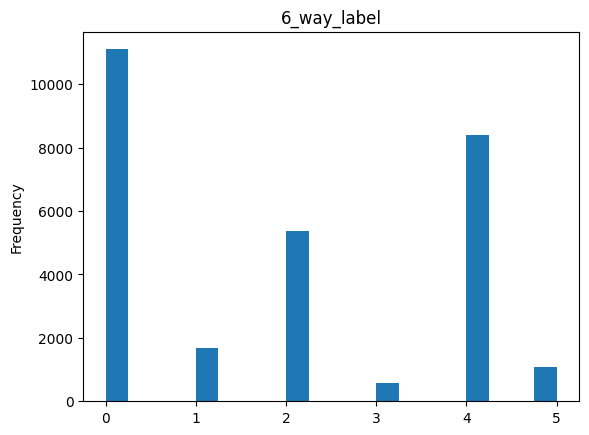

In [10]:
from matplotlib import pyplot as plt
df['6_way_label'].plot(kind='hist', bins=20, title='6_way_label')

> Based on the class distribution graph, we can say that the classes are not represented equally in the dataset.

> Due to this, I applied balanced class weights later on in my loss function

#### Importing images from url into working directory

- Used the `request` module from `urllib` library to handle the downloading of images from URLs.
- Any NaN values in the DataFrame are replaced with empty strings using `replace()` and `fillna()` methods. This ensures that there are no missing values when working with the data.
- Used `urlopen()` to download the image from the URL and write the content to a file. The file is saved with the id of the row and the extension .jpg, to enable easy future access
- I found that some image URLs do not exist anymore/ have been taken down, the corresponding rows are dropped from the DataFrame.

In [11]:
from urllib import request

# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Make a directory to download images into
if not os.path.exists("/kaggle/working/images"):
  os.makedirs("/kaggle/working/images")

for index, row in df.iterrows():
  if row["hasImage"] == True and row["image_url"] != "" and row["image_url"] != "nan":
    image_url = row["image_url"]
    path = "/kaggle/working/images/" + row["id"] + ".jpg"

    try:
      f = open(path, 'wb')
      f.write(request.urlopen(image_url).read())
      f.close()

    except:
        # To account for now invalid image urls
        df.drop(index = index, axis = 0, inplace = True)
        pass

print("Downloaded all images.")
df.reset_index(drop=True, inplace=True)

Downloaded all images.


(167, 320, 3)


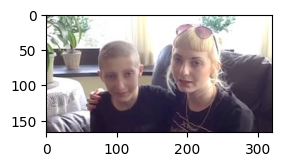

(184, 320)


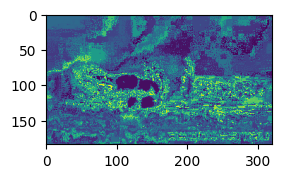

(480, 320)


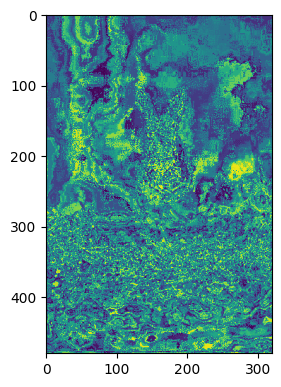

(213, 320, 3)


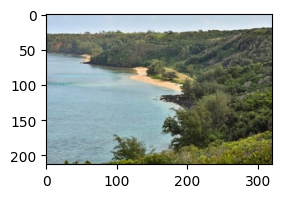

(167, 320, 3)


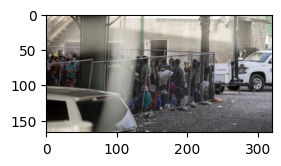

In [12]:
# Plotting images to test download
for i in range(5):
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

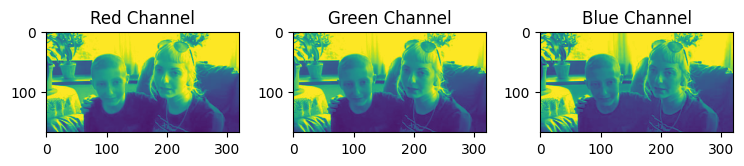

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the RGBA image
image_path = "/kaggle/working/images/" + df["id"][0] + ".jpg"
image = Image.open(image_path).convert("RGB")

# Split the image into individual channels
r, g, b = image.split()

# Plot each channel separately
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(r)
plt.title('Red Channel')

plt.subplot(1, 4, 2)
plt.imshow(g)
plt.title('Green Channel')

plt.subplot(1, 4, 3)
plt.imshow(b)
plt.title('Blue Channel')

#plt.subplot(1, 4, 4)
#plt.imshow(a)
#plt.title('Alpha Channel')

plt.tight_layout()
plt.show()

#### We have images of different sizes which will not work for a CNN


*   Checking for corrupt image files to avoid errors
*   Resizing images in (256, 256, 3) format
*   Testing images





> While attempting to resize images, I was facing errors with some corrupt image files (presumably downloaded from now-defunct links) so I run through image dataset to ensure all images can be successfully opened, else I dropped the corresponding rows from the Dataframe.



In [14]:
def validate_images(directory):
    corrupted_files = []

    # Walk through directory and sub-directories
    for index, row in df.iterrows():
      image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
      try:
          with Image.open(image_path) as img:
              img.verify()
      except Exception as e:
          corrupted_files.append(image_path)
          print(f"Error with {image_path}: {e}")
          df.drop(index = index, axis = 0, inplace = True)

    return corrupted_files

# Example usage:
directory = "/kaggle/working/images/"
corrupted_images = validate_images(directory)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
else:
    print("All images are valid!")
df.reset_index(drop=True, inplace=True)

Error with /kaggle/working/images/c1ehe8.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/c1ehe8.jpg'
Error with /kaggle/working/images/cdepx3z.jpg: cannot identify image file '/kaggle/working/images/cdepx3z.jpg'
Error with /kaggle/working/images/7s6k5y.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/7s6k5y.jpg'
Error with /kaggle/working/images/84lvcd.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/84lvcd.jpg'
Error with /kaggle/working/images/7ifug4.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/7ifug4.jpg'
Error with /kaggle/working/images/baoifi.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/baoifi.jpg'
Error with /kaggle/working/images/9im5b8.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/9im5b8.jpg'
Error with /kaggle/working/images/975vpp.jpg: [Errno 2] No such file or directory: '/kaggle/working/images/975vpp.jpg'
Error with /kaggle/working/images/b1htbz.jpg: [Errno 2] 

Resized all the images in dataset to a standard size of (256, 256) using PyTorch's `torchvision.transforms`. The resized images overwrite the original ones.
- Each image is converted to RGB format to ensure consistent color channels.
- Used PyTorch's `torchvision.transforms.Resize` to resize the image to the specified new_size.
- This is so I can pass all the images as uniform (256, 256, 3) matrixes in the CNN.

In [15]:
# Resizing all the images to a standard (256,256, 3) using pytorch

# Define the desired size
new_size = (256, 256)

for index, row in df.iterrows():
    image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")

    # Resize the image using PyTorch's torchvision.transforms
    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(256, 256, 3)


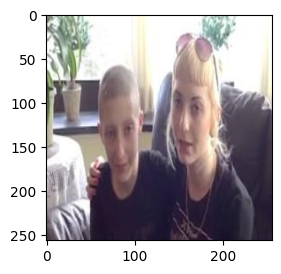

(256, 256, 3)


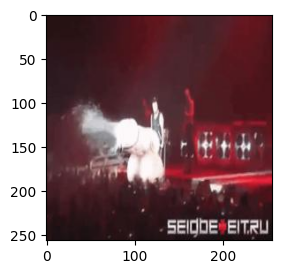

(256, 256, 3)


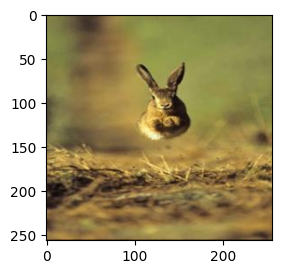

(256, 256, 3)


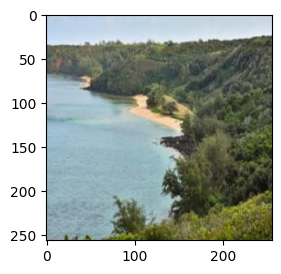

(256, 256, 3)


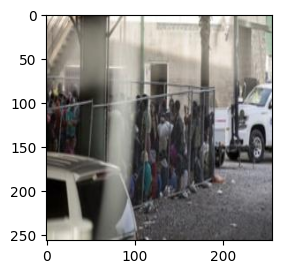

In [16]:
# Plotting images to test resize
for i in range(5):
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

#### Defining BERT Tokenizer to convert variable length clean-title strings to uniform 768-element arrays

- Using a pre-trained `BERT model` from the Hugging Face `transformers` library, I generated BERT embeddings for the Reddit title strings.
- BERT BASE has a feed-forward network of 768 hidden layers which results in a uniform length array everytime.
- These arrays can then be used in a Neural Network for classification tasks

In [17]:
%%capture

#Instsalling BERT and PyTorch into Colab

! pip install bert-serving-server  # server-side
! pip install bert-serving-client  # client-side
! pip install torch transformers

In [18]:
import torch
from transformers import BertModel, BertTokenizer

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states = True)

# Put the model in evaluation mode, which turns off dropout regularization which is used in training.
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
def get_bert_embedding(text):
    # Tokenize input text and get token IDs and attention mask
    inputs = tokenizer.encode_plus(text, add_special_tokens = True, return_tensors='pt', max_length=80, truncation=True, padding='max_length')

    return inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)

# Testing embedding
text = "This is an example Reddit submission title."
input_ids, attention_mask = get_bert_embedding(text)
print(input_ids.shape)
print(attention_mask.shape)
# print(embedding)

torch.Size([80])
torch.Size([80])


#### Loading and Processing Input Data

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["6_way_label"])
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test["6_way_label"])

> Created `FakedditDataset` class, inherited from PyTorch's `Dataset` class
  - Applies transforms to image
  - Returns:
    - `Image` in form of tensor
    - BERT tokenizer `input_ids` and `attention_masks`
    - corresponding 6-way `label`

> Upon applying normalization, model returned poor results (predicted all 0's). Hence, it's one of the transforms I decided not to apply

> FakedditDataset contains all relevant information per batch and DataLoader iterates over complete Dataset to feed batches of *size 16* to model

In [21]:
class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="6_way_label", image_id="id"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id

        self.img_size = 256
        # Using the pre-calculated ImageNet mean and std values for normalization
        self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

        self.transform_func = v2.Compose(
                [   v2.Resize(256),
                    v2.ToImage(),
                    v2.ToDtype(torch.float32, scale=True),
                    v2.Normalize(self.mean, self.std)
                    ])

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]
        img_path = "/kaggle/working/images/" + self.df.at[index, self.image_id] + ".jpg"

        image = Image.open(img_path)
        img = self.transform_func(image)

        input_ids, attention_mask = get_bert_embedding(text)

        return input_ids, attention_mask, label, img

    def __len__(self):
        return self.df.shape[0]

In [22]:
train_dataset = FakedditDataset(df_train)
test_dataset = FakedditDataset(df_test)
val_dataset = FakedditDataset(df_val)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

print(len(train_loader))

# Verifying dataset was created accurately
input_ids, attention_mask, label, img = next(iter(train_loader))
print(input_ids.shape, attention_mask.shape, label.shape, img.shape)

944
torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 256, 256])


#### Building the Model #1

`MultiModalClassifier` class processes post title and image data using `Bert-Base model` for processing text data and a `simple CNN-based model` for processing image data, and is derived of `nn.Module` model super class from torch.nn module.

##### Convolutional Neural Network:
*   The architecture of my model is derived from standard CNNs built to perform image classification tasks
*   I designed a simple architecture consisting of three convolutional layers to perform feature extraction with the following composition:
  - **2D convolution**: with a (3x3) kernel and 1 unit of padding.
  - **Activation**: ReLU is applied to introduce non-linearity.
  - **MaxPooling**: This layer reduces the spatial dimensions by half while maintaining number of channels.
*   Fully Connected Layer:
  - **Input**: The output from the last convolutional layer is flattened into a vector of size 128 * 32 * 32 = 131072.
  - **Output**: This vector is passed through a fully connected layer (linear layer) that maps it to a vector of size equal to the number of classes (num_classes).
  - **Activation**: ReLU is applied to the output of this layer.


---

##### Text Processing Branch
- To process the text, I utilized a pre-trained BERT model (`bert-base-uncased`) to process the text input.
- The BertModel outputs a 768-dimensional vector for each input token

- Linear Layer: Applied a fully connected layer to reduce the dimensionality of the BERT output to match the number of target classes (= 6).

---

*  I implemented a `dropout()` layer to prevent overfitting
*  I used the `torch.max()` function to merge the features from the text and image branches of multimodal model. This approach selects the maximum value between the corresponding elements of `x_text` and `x_img`.
  - This yielded better results than `torch.cat()` and `torch.mean()` to combine the layers of text and image
*   **Activation Function**: softmax()
  - Applied alongside CrossEntropyLoss loss function




In [24]:
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=6):

        super(MultimodalClassifier, self).__init__()

        self.num_classes = num_classes

        # Image processing (Simple CNN)
        self.image_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # output-> (32, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output-> (32, 128, 128)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # output-> (64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output-> (64, 64, 64)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # output-> (128, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # output-> (128, 32, 32)
        )

        # Image processing (Fully Connected Layers)
        self.image_fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, num_classes),  # Assuming input images are 256x256
            nn.ReLU()
        )

        # Dropout layer
        self.drop = nn.Dropout(p=0.3)

        # Text processing branch (using the 768-dimensional BERT arrays)
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)

        # Fusion and classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, text_input_ids, text_attention_mask,):
        # Image branch
        x_img = self.image_conv(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the feature maps
        x_img = self.image_fc(x_img)
        x_img = self.drop(x_img)

        # Text branch
        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.fc_text(x_text_pooled_output)
        x_text = self.drop(x_text)

        # Fusion and max merge
        x = torch.max(x_text, x_img)

        # Classification
        #x = self.softmax(x) #-> already applied in crossentropy loss

        return x

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultimodalClassifier(num_classes=6)
model= model.to(device)

#### Training and Evaluating the Model

Training Loop for Model:

*   **Loss Function**: `Weighted Cross Entropy Loss`, it also applies softmax activation function to return final probability distribution of classes
  *   I applied the `get_class_weights()` function to calculate percentage values per class for a weighted CrossEntropy. Thus is because of the highly imbalanced Fakeddit dataset. Since, some classes have considerably more sample data, all classes are weighted and taken as input into the loss calculation according to their respective number of samples.
*   **Early Stopping**: To stop training if loss is increasing
*   **Optimizer**: Adam
*   **Learning Rate**: 1e-4
*   **Epochs:** 5




In [26]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [27]:
labels = df_train['6_way_label'].to_numpy()
#type(labels)

In [28]:
# Define loss function and optimizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'labels' is a list of all labels in the dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.5, patience=1, verbose=True)
num_epochs = 20

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
  # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for input_ids, attention_mask, label, img in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)
                
            optimizer.zero_grad()

          # Forward pass
            outputs = model(img, input_ids, attention_mask)
            loss = criterion(outputs, label)

          # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()* img.size(0)
            
       # Validating model and ensuring loss is decreasing     
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        with torch.no_grad():
            for input_ids, attention_mask, label, img in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)
    
                outputs = model(img, input_ids, attention_mask)
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == label)

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct_preds.double() / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader.dataset):.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

  #torch.save(model.state_dict(), '/content/drive/MyDrive/model2.pth')

Evaluation loop for model:

In [29]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_losses = []
    correct_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, label, img in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            outputs = model(
                  image = img,
                  text_input_ids = input_ids,
                  text_attention_mask = attention_mask
            )

            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)
            #print(outputs)

            # Loss is calculated by applying Cross Entropy Loss
            val_loss = criterion(outputs, label)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == label)
            print(preds, label)

            # Appending current loss per batch to list of losses per epoch
            val_losses.append(val_loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            

    accuracy = float((correct_preds.double() / len(df_test)) * 100)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print("\nAccuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

In [30]:
#train_model(model, train_loader, criterion, optimizer, num_epochs)
print("\n")
#evaluate_model(model, test_loader, criterion)

Post training insights for BERT + CNN multimodal model:
- NOTE: ran only 4 epochs to get faster results for these insights
- Ran on approx. 2000 rows of data

```
Data:

# During training:
Epoch [1/4], Loss: 1.7745
Epoch [2/4], Loss: 1.7183
Epoch [3/4], Loss: 1.5023
Epoch [4/4], Loss: 1.2373

# Accuracy:
Accuracy:  58.994708994709

#Sample test output:
-> model output: tensor([1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 1, 2, 2, 0, 2])
-> expected output: tensor([1, 5, 0, 4, 2, 3, 0, 0, 2, 0, 2, 1, 0, 2, 2, 0])
```



#### Building Improved Model

`BERTResNetClassifier` class processes post title and image data using `Bert-Base model` for processing text data and a `ResNet model` for processing image data, and is derived of `nn.Module` model super class from torch.nn module.

Sample Reference upon which I based my model architecture:
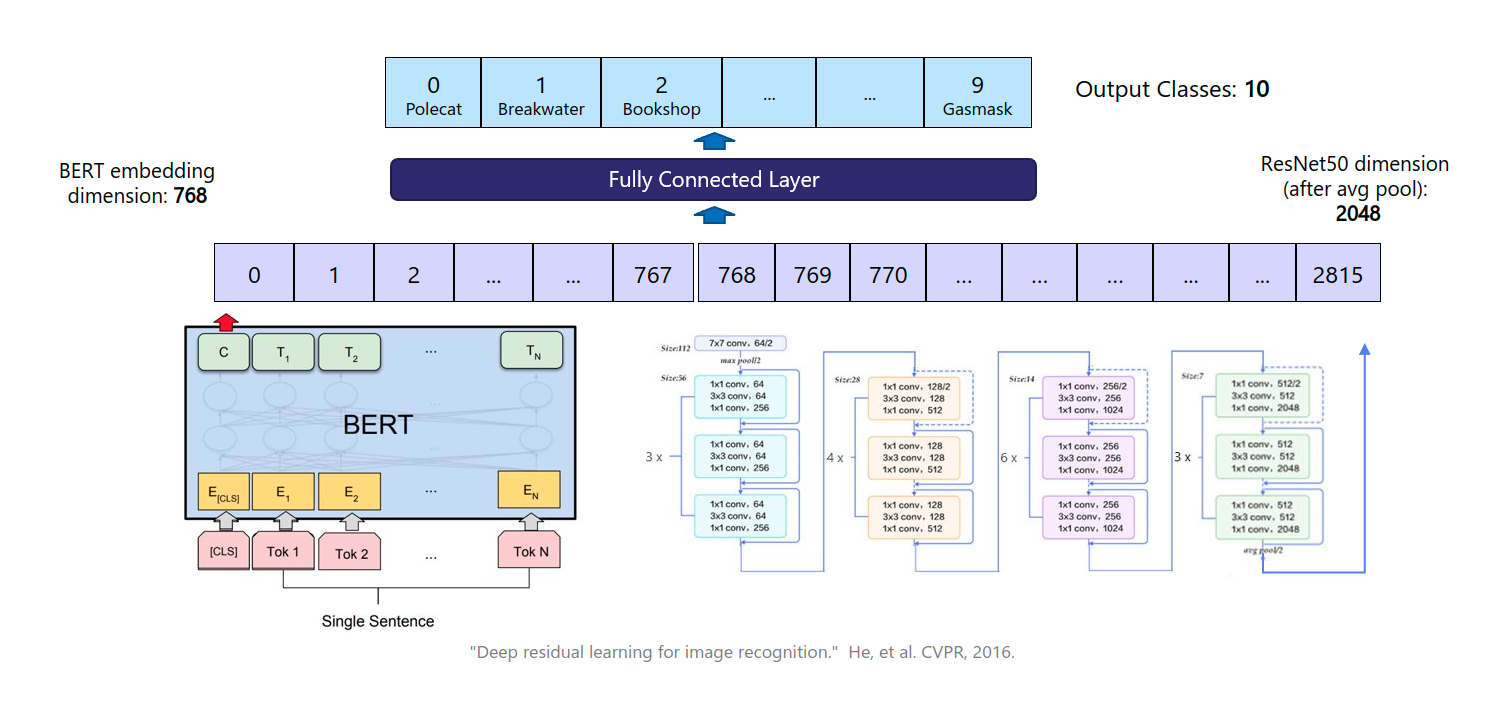

##### Why switch to ResNets vs shallow CNNs?
*   Residual Network (ResNet) are a Convolutional Neural Network (CNN) architecture that overcomes the “vanishing gradient” problem using shortcut connections
*   ResNets have shown better accuracy than shallow CNNs when training on smaller image datasets.
*   Compared to other CNN models, ResNet-50 has a smaller loss value and converges faster.
*   ResNet50 achieves better parameter efficiency due to its bottleneck architecture, where 1x1 convolutions are used to reduce and then restore the dimensionality of the data

---

*  I continued to use the `torch.max()` function to merge the features from the text and image branches of multimodal model.
*   **Activation Function**: `softmax()`
  - Applied alongside CrossEntropyLoss loss function




In [31]:
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6):

        super(BERTResNetClassifier, self).__init__()

        self.num_classes = num_classes

        # Image processing (ResNet)
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Image processing (Fully Connected Layer)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

        # Dropout layer
        self.drop = nn.Dropout(p=0.3)

        # Text processing (using the 768-dimensional BERT arrays)
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Text processing (Fully Connected Layer)
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)

        # Fusion and classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, text_input_ids, text_attention_mask,):
        # Image branch
        x_img = self.image_model(image)
        x_img = self.drop(x_img)
        x_img = self.fc_image(x_img)

        # Text branch
        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.drop(x_text_pooled_output)
        x_text = self.fc_text(x_text_pooled_output)

        # Fusion and max merge
        x = torch.max(x_text, x_img)

        # Classification
        #x = self.softmax(x) #-> already applied in crossentropy loss

        return x

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BERTResNetClassifier(num_classes=6)
model= model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.5, patience=1, verbose=True)
num_epochs = 20

train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
#print("\n")
evaluate_model(model, test_loader, criterion)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Epoch 1/20, Training Loss: 1.1910, Validation Loss: 0.9545, Accuracy: 0.6598
Epoch 2/20, Training Loss: 0.6887, Validation Loss: 0.9283, Accuracy: 0.6741
Epoch 3/20, Training Loss: 0.4285, Validation Loss: 1.0781, Accuracy: 0.7462
EarlyStopping counter: 1 out of 5
Epoch 00004: reducing learning rate of group 0 to 5.0000e-06.
Epoch 4/20, Training Loss: 0.2734, Validation Loss: 1.1885, Accuracy: 0.7276
EarlyStopping counter: 2 out of 5
Epoch 5/20, Training Loss: 0.1629, Validation Loss: 1.3538, Accuracy: 0.7594
EarlyStopping counter: 3 out of 5
Epoch 00006: reducing learning rate of group 0 to 2.5000e-06.
Epoch 6/20, Training Loss: 0.1244, Validation Loss: 1.4256, Accuracy: 0.7573
EarlyStopping counter: 4 out of 5
Epoch 7/20, Training Loss: 0.0935, Validation Loss: 1.6587, Accuracy: 0.7679
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.
tensor([2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0], device='cuda:0') tensor([2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2

# Personal Notes on BERT


*   The decision to use an encoder-only architecture in BERT suggests a primary emphasis on understanding input sequences rather than generating output sequences.
*    BERT uses a bi-directional approach considering both the left and right context of words in a sentence, instead of analyzing the text sequentially
*   BERT is pre-trained on large amount of unlabeled text data. The model learns contextual embeddings, which are the representations of words that take into account their surrounding context in a sentence.
*   BERT is fine-tuned using labeled data specific to the downstream tasks of interest. These tasks could include sentiment analysis, question-answering, named entity recognition, or any other NLP application.


### Architecture:
*   BERT*BASE* has 12 layers in the Encoder stack while BERT*LARGE* has 24 layers in the Encoder stack.
*   BERT architectures (BASE and LARGE) also have larger feedforward networks (768 and 1024 hidden units respectively), and more attention heads (12 and 16 respectively)

---


*   https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/
*   https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
*   https://jalammar.github.io/illustrated-bert/











# Personal Notes on ResNets

*   The groundbreaking contribution of ResNet is the introduction of the *residual block*. These residual blocks allow connecting the activations of previous layers with the next while skipping some layers in between, allowing the gradient to flow without being altered by a large magnitude.
*   ResNet blocks can result in dimensionality mismatches which we can fix by passing outputs through 1x1 convolutions with strides of 2 rather than adding extra padding
    - (ex: if we had 3 input channels and 6 output channels, we would pass input through 3 1x1 convolutional layers to double number of input channels)
    - (ex: stride of 2 ensures that 64x64 layer would become 32x32)


### ResNets vs VGG?
I also considered using VGG for Image Classification but saw upon research that ResNets were found to be more effective
*   ResNet50 is significantly deeper than VGG in terms of architecture. One of the drawbacks of VGG was that researchers couldn't go as deep as wanted, because they started to lose generalization capability.
*   ResNet50 had smoother training and faster convergence, thanks to the skip connections


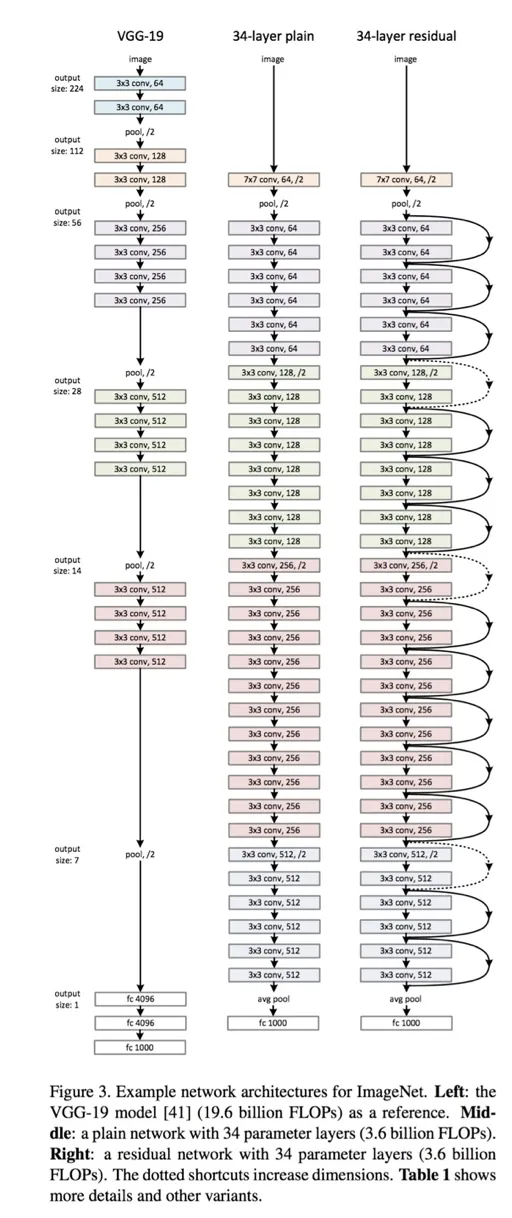

---

*   https://www.youtube.com/watch?v=o_3mboe1jYI
*   https://www.kaggle.com/code/rchesak/cnn-vs-resnet50-trained-on-20-images
*   https://wandb.ai/mostafaibrahim17/ml-articles/reports/The-Basics-of-ResNet50---Vmlldzo2NDkw
*  https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8




# Early Fusion vs Late Fusion

- Early fusion approach combines raw data from multiple sensors before any high-level processing or decision-making. It helps capture and process interactions between modalities at the data level. 
    - The advantage here is that we don’t have to perform dedicated processing for each modality (i.e, it only requires a single learning phase)
    - The downside to this approach is that raw input data may not contain rich semantic information. This means that the model is not able to capture complex interactions between the modalities.
- Late fusion approach processes the data of each sensor independently to make a local prediction. These individual results are then combined at a higher level to make the final fused prediction.
    - The advantage of late fusion is its simplicity and isolation. Each model gets to learn super rich information on its modality.
    - The downside is that system is not able to learn complex modal interactions, and thus does not benefit directly from the complementary information each modality might offer.
    - Another downside is the high compute cost for processing data of each mode separately.

    
Ultimately I chose to do Late Fusion as it seemed to have generally better results for image-text models.

---
- https://medium.com/@raj.pulapakura/multimodal-models-and-fusion-a-complete-guide-225ca91f6861
- https://chaozhangchn.medium.com/performance-comparison-between-early-fusion-and-late-fusion-5f9d88ffce66
- https://dl.acm.org/doi/pdf/10.1145/3589335.3652504